## zad.1
Napisać własną implementację interpolacji wielomianowej stosując wprost wzór na wielomian interpolacyjny Lagrange'a . Przetestować swoją implementację na wylosowanych węzłach interpolacji w wybranym przedziale. Narysować wykres wielomianu interpolacyjnego w tym przedziale wraz z wezlami interpolacji.

In [1]:
using Polynomials, Plots, Interpolations, LinearAlgebra, DataFrames, Statistics

In [2]:
function lagrange_base(X, x, k, n)
    base = [(x - X[i]) / (X[k] - X[i]) for i in 1:n if i != k]
    return prod(base)
end

lagrange_base (generic function with 1 method)

In [3]:
function lagrange_value(X, Y, x)
    n = length(X)
    values = [Y[i] * lagrange_base(X, x, X[i], n) for i in 1:n]
    return sum(values)
end

lagrange_value (generic function with 1 method)

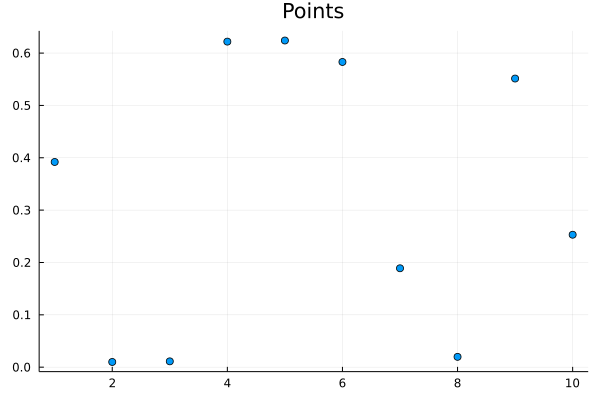

In [4]:
X = [i for i in 1:10]
Y = [rand() for x in X]
scatter(X, Y, title="Points", legend=false)

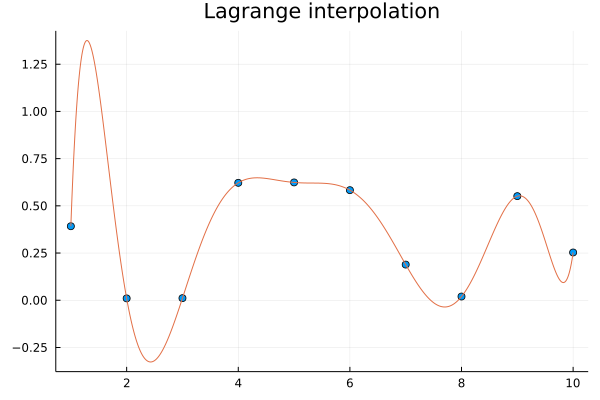

In [5]:
xs = 1:0.01:10
ys = [lagrange_value(X, Y, i) for i in xs]
plot!(xs, ys, title="Lagrange interpolation")

## zad.2
Zrobic to samo dla metody Newtona (metoda ilorazów róznicowych).Narysować wykres wielomianu interpolacyjnego otrzymanego metodą Newtona dla tych samych danych, co w poprzednim punkcie. Zadbać o to, żeby ilorazy wyliczać tylko raz dla danego zbioru wezłow interpolacji, według schematu z pakietu Interpolations http://juliamath.github.io/Interpolations.jl/stable/interpolations/ :

<b>A</b> napisać funkcję NewtonInterpolation, która wylicza ilorazy różnicowe i zwraca "obiekt interpolacyjny" newt
<br>
<b>B</b> napisać funkcję która wylicza wartość wielomianu dla obiektu newt w punkcie x za pomocą schematu Hornera dla postaci Newtona

In [6]:
function NewtonInterpolation(X, Y)
    n = length(X)
    M = zeros(Float64, (n, n))
    
    # zerowe ilorazy różnicowy
    for i in 1:n
        M[i, 1] = Y[i]
    end
    
    # pierwsze ilorazy różnicowe
    for i in 2:n
        M[i, 2] = (M[i, 1] - M[i - 1, 1]) / (X[i] - X[i - 1])
    end
    
    # kolejne ilorazy różnicowe
    for i in 3:n
        for j in i:n
            M[j, i] = (M[j, i - 1] - M[j - 1, i - 1]) / (X[j] - X[j - i + 1])
        end
    end
    
    newt = [M[i, i] for i in 1:n]
    return newt
end

NewtonInterpolation (generic function with 1 method)

In [7]:
function horners_method(X, x, newt)
    n = length(X)
    b = newt[n]
    for i in (n-1):(-1):1
        b = b * (x - X[i]) + newt[i]
    end
    return b
end

horners_method (generic function with 1 method)

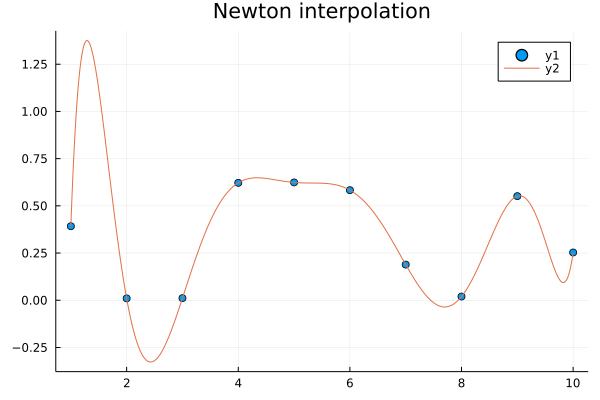

In [8]:
scatter(X, Y, title="Points")
newt = NewtonInterpolation(X, Y)
ys = [horners_method(X, i, newt) for i in xs]
plot!(xs, ys, title="Newton interpolation")

## zad.3
Zastosować interpolację wielomianową z pakietu Polynomials do tych samych danych, co w poprzednich punktach. Porównać wszystkie 3 wyniki interpolacji wielomianowej na jednym wykresie. Co zauważamy? Dlaczego?

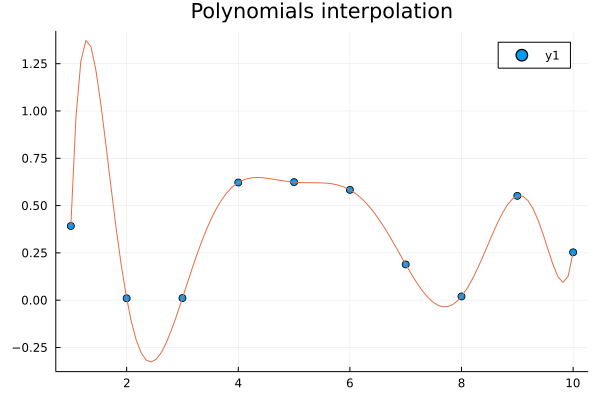

In [9]:
scatter(X, Y, title="Points")
package = fit(X, Y)
plot!(package, extrema(X)..., title="Polynomials interpolation", label=false)

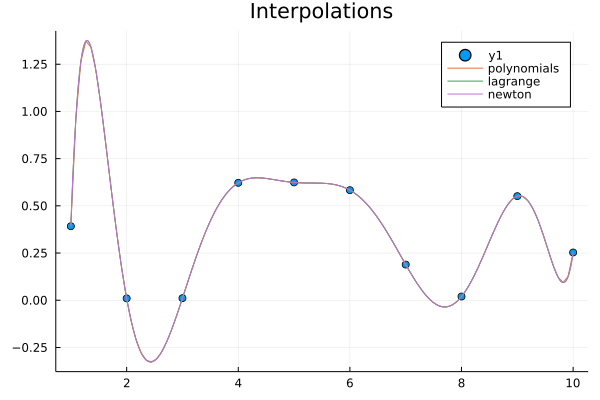

In [10]:
scatter(X, Y, title="Interpolations")

package = fit(X, Y)
plot!(package, extrema(X)..., label="polynomials")

ys_l = [lagrange_value(X, Y, i) for i in xs]
plot!(xs, ys_l, label="lagrange")

newt = NewtonInterpolation(X, Y)
ys_n = [horners_method(X, i, newt) for i in xs]
plot!(xs, ys_n, label="newton")

Widzimy, że wykresy wielomianów pokrywają się. Jest to coś, czego oczekiwaliśmy, ponieważ zgadza się to z twierdzeniem o jednoznaczności interpolacji wielomianowej.

## zad.4
Porównać metody poprzez pomiar czasu wykonania dla zmiennej ilości węzłow interpolacji. Uwaga: dodatkowo, dla metody Newtona i pakietu Polynomials należy osobno zmierzyć czas wyliczania wielomianu i osobno czas wyliczania wartości w punkcie. Dokonać pomiaru 10 razy i policzyć wartość średnią oraz oszacować błąd pomiaru za pomocą odchylenia standardowego; wyniki przedstawić na wykresach. Jako narzędzie do analizy danych użyć Julia DataFrames 

In [11]:
function generate_random_points(n)
    X = [i for i in 1:n]
    Y = [rand() for x in X]
    return X, Y
end

generate_random_points (generic function with 1 method)

In [12]:
function lagrange_time(X, Y, range)
    return sum([@elapsed lagrange_value(X, Y, a) for a in range])
end

function newton_time(X, Y, range)
    newt = NewtonInterpolation(X, Y)
    fst = @elapsed NewtonInterpolation(X, Y)
    snd = sum([@elapsed horners_method(X, b, newt) for b in range])
    return fst + snd
end

function polynomials_time(X, Y, range)
    package = fit(X, Y)
    fst = @elapsed fit(X, Y)
    snd = sum([@elapsed package(c) for c in range])
    return fst + snd
end

polynomials_time (generic function with 1 method)

In [42]:
df1 = DataFrame(points = Int64[], interpolation = String[], time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [43]:
jump = 10
treadmill = jump:jump:10*jump

10:10:100

In [44]:
for i in treadmill
    range = 1:0.01:i
    for j in 1:10
        X, Y = generate_random_points(i)
        push!(df1, [i "lagrange" lagrange_time(X, Y, range)])
        push!(df1, [i "newton" newton_time(X, Y, range)])
        push!(df1, [i "polynomials" polynomials_time(X, Y, range)])
    end
end
df1

,points,interpolation,time
,Int64,String,Float64
1,10,lagrange,0.0047247
2,10,newton,5.44e-5
3,10,polynomials,5.5e-5
4,10,lagrange,0.0048703
5,10,newton,5.32e-5
6,10,polynomials,5.46e-5
7,10,lagrange,0.0050362
8,10,newton,5.36e-5
9,10,polynomials,5.27e-5


In [45]:
df1_grouped = groupby(df1, [:points, :interpolation])

,points,interpolation,time
,Int64,String,Float64
1,10,lagrange,0.0047247
2,10,lagrange,0.0048703
3,10,lagrange,0.0050362
4,10,lagrange,0.0049417
5,10,lagrange,0.0349639
6,10,lagrange,0.0062411
7,10,lagrange,0.0053657
8,10,lagrange,0.005296
9,10,lagrange,0.0057862


In [46]:
df1_combined = combine(df1_grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,10,lagrange,0.00845718,0.00934699
2,10,newton,5.354e-5,4.62361e-7
3,10,polynomials,5.425e-5,2.23371e-6
4,20,lagrange,0.0281877,0.0113849
5,20,newton,0.00012633,6.70075e-7
6,20,polynomials,0.00012247,3.62646e-6
7,30,lagrange,0.0714858,0.00955807
8,30,newton,0.00024206,6.43208e-5
9,30,polynomials,0.00022931,6.17675e-5


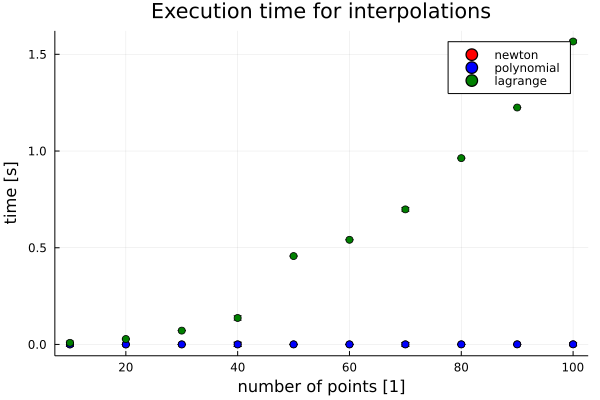

In [47]:
scatter([df1_combined[df1_combined[:,2] .== "newton", :].points df1_combined[df1_combined[:,2] .== "polynomials", :].points df1_combined[df1_combined[:,2] .== "lagrange", :].points],
    [df1_combined[df1_combined[:,2] .== "newton", :].time_mean df1_combined[df1_combined[:,2] .== "polynomials", :].time_mean df1_combined[df1_combined[:,2] .== "lagrange", :].time_mean],
    colour = [:red :blue :green],
    yerr = df1_combined.time_std,
    label = ["newton" "polynomial" "lagrange"],
    title = "Execution time for interpolations",
    xlab = "number of points [1]",
    ylab = "time [s]"
)

In [48]:
function newton_preparation_time(X, Y)
    return @elapsed NewtonInterpolation(X, Y)
end

function polynomials_preparation_time(X, Y)
    return @elapsed fit(X, Y)
end

polynomials_preparation_time (generic function with 1 method)

In [49]:
df2 = DataFrame(points = Int64[], interpolation = String[], time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [50]:
jump = 200
treadmill = jump:jump:10*jump

200:200:2000

In [51]:
for i in treadmill
    for j in 1:10
        X, Y = generate_random_points(i)
        push!(df2, [i "newton" newton_preparation_time(X, Y)])
        push!(df2, [i "polynomials" polynomials_preparation_time(X, Y)])
    end
end
df2

,points,interpolation,time
,Int64,String,Float64
1,200,newton,0.0001854
2,200,polynomials,9.75e-5
3,200,newton,0.0002122
4,200,polynomials,7.27e-5
5,200,newton,8.03e-5
6,200,polynomials,7.11e-5
7,200,newton,8.07e-5
8,200,polynomials,7.1e-5
9,200,newton,0.0001389


In [52]:
df2_grouped = groupby(df2, [:points, :interpolation])

,points,interpolation,time
,Int64,String,Float64
1,200,newton,0.0001854
2,200,newton,0.0002122
3,200,newton,8.03e-5
4,200,newton,8.07e-5
5,200,newton,0.0001389
6,200,newton,0.0001841
7,200,newton,0.0001943
8,200,newton,0.0001968
9,200,newton,0.0001958


In [53]:
df2_combined = combine(df2_grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,200,newton,0.00016615,4.89441e-5
2,200,polynomials,7.357e-5,8.4392e-6
3,400,newton,0.00059795,8.8163e-5
4,400,polynomials,0.00031292,7.06063e-5
5,600,newton,0.00258301,0.00421292
6,600,polynomials,0.00062984,1.15006e-5
7,800,newton,0.00228266,1.73438e-5
8,800,polynomials,0.00111424,2.08992e-5
9,1000,newton,0.00522043,0.00339465


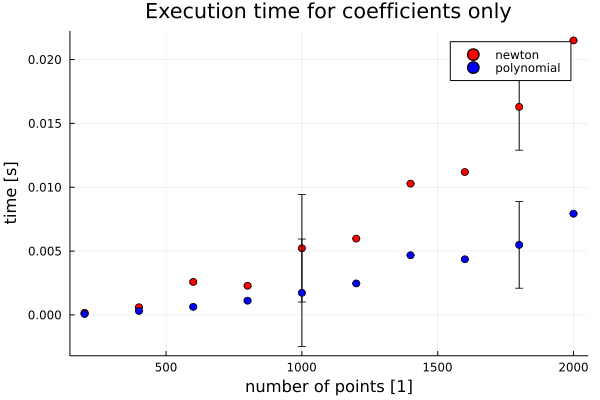

In [54]:
scatter([df2_combined[df2_combined[:,2] .== "newton", :].points df2_combined[df2_combined[:,2] .== "polynomials", :].points],
    [df2_combined[df2_combined[:,2] .== "newton", :].time_mean df2_combined[df2_combined[:,2] .== "polynomials", :].time_mean],
    colour = [:red :blue],
    yerr = df2_combined.time_std,
    label = ["newton" "polynomial"],
    title = "Execution time for coefficients only",
    xlab = "number of points [1]",
    ylab = "time [s]"
)

In [55]:
function newton_values_time(X, Y, range)
    newt = NewtonInterpolation(X, Y)
    return sum([@elapsed horners_method(X, b, newt) for b in range])
end

function polynomials_values_time(X, Y, range)
    package = fit(X, Y)
    return sum([@elapsed package(c) for c in range])
end

polynomials_values_time (generic function with 1 method)

In [56]:
df3 = DataFrame(points = Int64[], interpolation = String[], time = Float64[])

,points,interpolation,time
,Int64,String,Float64


In [57]:
jump = 100
treadmill = jump:jump:10*jump

100:100:1000

In [58]:
for i in treadmill
    range = 1:0.01:i
    for j in 1:10
        X, Y = generate_random_points(i)
        push!(df3, [i "newton" newton_values_time(X, Y, range)])
        push!(df3, [i "polynomials" polynomials_values_time(X, Y, range)])
    end
end
df3

,points,interpolation,time
,Int64,String,Float64
1,100,newton,0.0012821
2,100,polynomials,0.0010659
3,100,newton,0.0012916
4,100,polynomials,0.0010637
5,100,newton,0.0012799
6,100,polynomials,0.0011604
7,100,newton,0.0012795
8,100,polynomials,0.0010648
9,100,newton,0.0012798


In [59]:
df3_grouped = groupby(df3, [:points, :interpolation])

,points,interpolation,time
,Int64,String,Float64
1,100,newton,0.0012821
2,100,newton,0.0012916
3,100,newton,0.0012799
4,100,newton,0.0012795
5,100,newton,0.0012798
6,100,newton,0.0012779
7,100,newton,0.0012772
8,100,newton,0.0012987
9,100,newton,0.0013334


In [60]:
df3_combined = combine(df3_grouped, "time" => mean, "time" => std)

,points,interpolation,time_mean,time_std
,Int64,String,Float64,Float64
1,100,newton,0.00128952,1.72384e-5
2,100,polynomials,0.00107409,3.03435e-5
3,200,newton,0.00390773,0.000241389
4,200,polynomials,0.00296494,4.38006e-6
5,300,newton,0.00780362,0.000177541
6,300,polynomials,0.0045542,0.000152459
7,400,newton,0.0132436,0.00108708
8,400,polynomials,0.00655016,0.00140621
9,500,newton,0.0195064,0.000516057


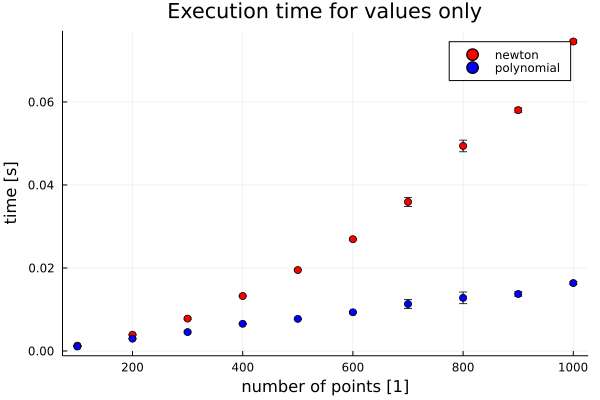

In [61]:
scatter([df3_combined[df3_combined[:,2] .== "newton", :].points df3_combined[df3_combined[:,2] .== "polynomials", :].points],
    [df3_combined[df3_combined[:,2] .== "newton", :].time_mean df3_combined[df3_combined[:,2] .== "polynomials", :].time_mean],
    colour = [:red :blue],
    yerr = df3_combined.time_std,
    label = ["newton" "polynomial"],
    title = "Execution time for values only",
    xlab = "number of points [1]",
    ylab = "time [s]"
)

## zad.5
Zaimplementować algorytm Neville’a i sprawdzić (dla kilku wybranych punktów), czy daje te same wartości wielomianu co wybrana interpolacja wielomianowa.

In [62]:
function neville(X, Y, x)
    n = length(X)
    P = zeros(Float64, n)
    
    for i in 1:n
        P[i] = Y[i]
        for j in i-1:-1:1
            P[j] = P[j+1] + (P[j+1] - P[j]) * (x - X[i]) / (X[i] - X[j])
        end
    end
    
    return P[1]
end

neville (generic function with 1 method)

In [63]:
X = [i for i in 1:10]
Y = [rand() for x in X]
xs = [1.23, 2.54, 4.19, 6.43, 8.89]
newt = NewtonInterpolation(X, Y)

10-element Vector{Float64}:
  0.06309996817646302
  0.6161462061603774
 -0.5740539696164864
  0.29344532446142396
 -0.0919842373508637
  0.020125134234844265
 -0.0031021546806296683
  9.968660510534895e-5
  0.00017007912350956437
 -8.332846933291193e-5

In [64]:
for x in xs
    newton = horners_method(X, x, newt)
    nevil = neville(X, Y, x)
    println("Point: ", x, " Newton: ", newton, " Neville: ", nevil, " Difference: ", abs(newton - nevil))
end

Point: 1.23 Newton: 0.10297315552228273 Neville: 0.1029731555222817 Difference: 1.0269562977782698e-15
Point: 2.54 Newton: 0.4084475649713877 Neville: 0.40844756497138746 Difference: 2.220446049250313e-16
Point: 4.19 Newton: 0.29303176647760343 Neville: 0.2930317664776039 Difference: 4.996003610813204e-16
Point: 6.43 Newton: 0.792221162499446 Neville: 0.7922211624994469 Difference: 8.881784197001252e-16
Point: 8.89 Newton: 0.24884215501990875 Neville: 0.24884215501991414 Difference: 5.384581669432009e-15


## zad.6
Poeksperymentować z  interpolacją funkcjami sklejanymi (minimum dwie różne funkcje sklejane),  narysować wykresy i porównać z wykresami interpolacji wielomianowej. <b>Zademonstrować  efekt Rungego</b>

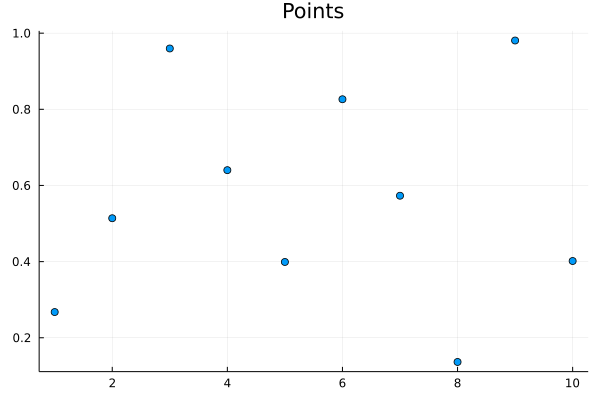

In [65]:
X = 1:10
Y = [rand() for x in X]
scatter(X, Y, label="", title="Points")

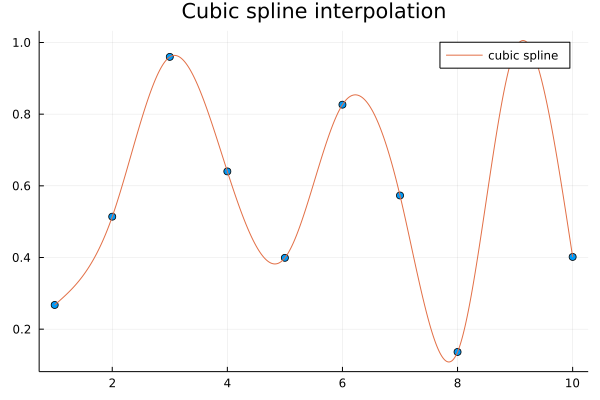

In [66]:
xs = [i for i in 1:0.01:10]
cubic_spline = CubicSplineInterpolation(X, Y)
ys_spline = [cubic_spline(x) for x in xs]
plot!(xs, ys_spline, label="cubic spline", title="Cubic spline interpolation")

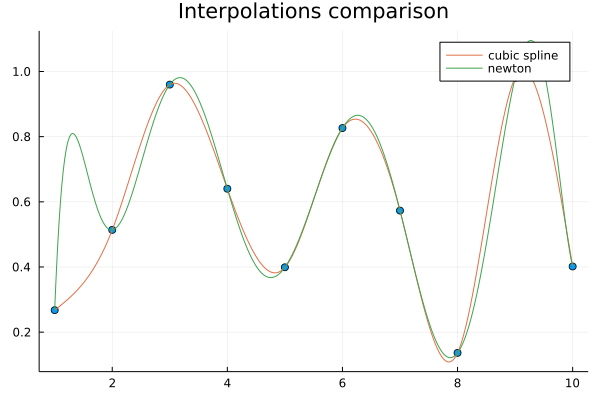

In [67]:
newt = NewtonInterpolation(X, Y)

ys_newton = [horners_method(X, x, newt) for x in xs]
plot!(xs, ys_newton, label="newton", title="Interpolations comparison")

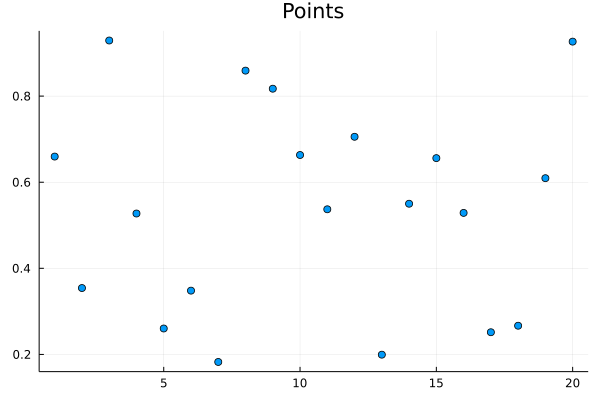

In [68]:
X = 1:20
Y = [rand() for x in X]
scatter(X, Y, label="", title="Points")

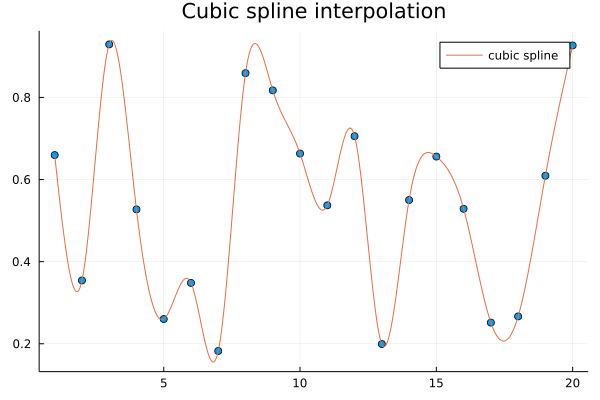

In [69]:
xs = [i for i in 1:0.01:20]
cubic_spline = CubicSplineInterpolation(X, Y)
ys_spline = [cubic_spline(x) for x in xs]
plot!(xs, ys_spline, label="cubic spline", title="Cubic spline interpolation")

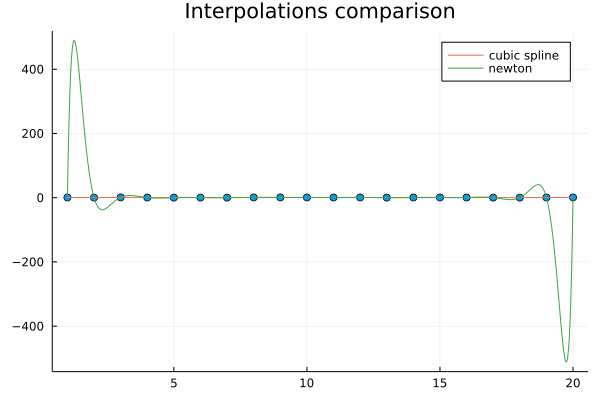

In [70]:
newt = NewtonInterpolation(X, Y)

ys_newton = [horners_method(X, x, newt) for x in xs]
plot!(xs, ys_newton, label="newton", title="Interpolations comparison")

Im więcej mamy węzłów interpolacji, tym gorszym pomysłem jest korzystanie z metody Newtona. 
Na krańcach przedziału obserwujemy efekt Rungego, który dla 20 węzłów absurdalnie zaburza otrzymane wyniki

Konstrukcja wielomianu z wykorzystaniem funkcji sklejanych daje sensowne rezultaty i jest lepszym wyborem od próby konstrukcji wielomianu bardzo wysokiego stopnia